# KNN Algorithm Implementation and Analysis on the CIFAR-100 Dataset

Checking python version to ensure the code is running on Python 3

In [1]:
!python -V

Python 3.7.6


## Data Loading and Exploration
The CIFAR-100 dataset has two labels: coarse and fine, where the coarse labels correspond to 20 high level labels and the fine labels correspond to 100 low level labels. For this assignment we will use the coarse labels as our dataset of analysis.

In [2]:
import tensorflow as tf

(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar100.load_data(label_mode='coarse')

In [3]:
train_data.shape

(50000, 32, 32, 3)

In [4]:
train_labels.shape

(50000, 1)

Text(0.5, 1.0, 'class [11]')

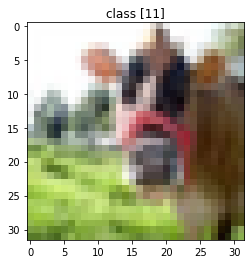

In [5]:
import matplotlib.pyplot as plt

plt.imshow(train_data[0])
plt.title("class " + str(train_labels[0]))

## Pre-processing the dataset
We will preprocess the dataset by normalisation and Principal Component Analysis using Singular Value Decomposition.

1. Normalisation:

   Normalisation is done by subtracting the mean of each feature from the entire sample of features and then dividing the          features by their corresponding standard deviations. These vectors of means and standard deviations are retained to transform 
   the test set to adhere to the same distribution as that of the training set.


2. PCA using SVD
   
   We perform PCA using the singular values obtained by SVD, we reduce the number of features by taking into account those          features that are responsible for 80% of the total variance. We retain the eigenvectors to transform the test set.

In [3]:
train_data = train_data.reshape((train_data.shape[0],32*32*3))
train_data.shape

(50000, 3072)

In [4]:
import numpy as np

means = np.mean(train_data, axis = 0)
stds = np.std(train_data, axis = 0)

train_data = train_data - means
train_data = train_data/stds

In [5]:
from scipy import linalg
U, S, VT = linalg.svd(train_data, full_matrices = False)

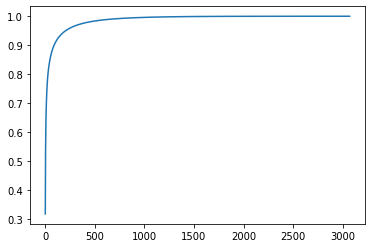

In [6]:
import matplotlib.pyplot as plt

explained_variance = pow(S,2)/(S.shape[0] - 1)
total_variance = np.sum(explained_variance)
explained_variance_ratio = explained_variance/total_variance

plt.plot(np.cumsum(explained_variance_ratio))

In [7]:
n = np.where(np.cumsum(explained_variance_ratio) > 0.8)[0][0]

In [8]:
S = np.diag(S)
train_data = np.dot(U[0:train_data.shape[0],0:n], S[0:n, 0:n])
train_data.shape

(50000, 27)

In [9]:
test_data = test_data.reshape((test_data.shape[0], 32*32*3))

test_data = test_data - means
test_data = test_data/stds

test_data = np.dot(test_data, VT[0:n,0:32*32*3].T)    
test_data.shape

(10000, 27)

## Training and Hyperparameter Tuning

Hyperparameter tuning is done by using grid search over a list of possible neighbours: [5,10,15,20,25,30,35] 

We also perform 10 fold cross-validation to get an accurate indication of the general performance of a certain value of k 

In [16]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

train_labels = train_labels.reshape((train_labels.shape[0],))
test_labels = test_labels.reshape((test_labels.shape[0],))

for n in [5,10,15,20,25,30]:
    
    model = KNeighborsClassifier(n_neighbors=n)
    accs = cross_val_score(model, train_data, train_labels, cv=10)
    acc = np.mean(accs)
    
    model.fit(train_data, train_labels)
    predictions = model.predict(test_data)
    correct = np.where(predictions == test_labels,1,0)
    print('k = ' ,n, ' CV_Accuracy = ', acc,' Test Accuracy = ', np.sum(correct)/len(test_labels))

k =  5  CV_Accuracy =  0.27664  Test Accuracy =  0.2767
k =  10  CV_Accuracy =  0.28506  Test Accuracy =  0.2879
k =  15  CV_Accuracy =  0.28856000000000004  Test Accuracy =  0.2905
k =  20  CV_Accuracy =  0.28758  Test Accuracy =  0.2903
k =  25  CV_Accuracy =  0.28572  Test Accuracy =  0.2889
k =  30  CV_Accuracy =  0.28458  Test Accuracy =  0.2874
Wall time: 9min 10s


## Observations

We produce the precision and recall table that shows the precision and recall for all features as well as an average of all features.

We also showcase a confusion matrix with brighter colours showing larger values.

In [16]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

n = 15 #best hyperparameter

model = KNeighborsClassifier(n_neighbors=n)
model.fit(train_data, train_labels)
predictions = model.predict(test_data)
correct = np.where(predictions == test_labels,1,0)
print('k = ' ,n, ' CV_Accuracy = ', acc,' Test Accuracy = ', np.sum(correct)/len(test_labels))


print(metrics.classification_report(test_labels, predictions))

k =  15  CV_Accuracy =  0.33774  Test Accuracy =  0.2905
              precision    recall  f1-score   support

           0       0.24      0.30      0.27       500
           1       0.32      0.37      0.34       500
           2       0.44      0.44      0.44       500
           3       0.32      0.42      0.37       500
           4       0.50      0.37      0.42       500
           5       0.29      0.24      0.26       500
           6       0.31      0.29      0.30       500
           7       0.31      0.33      0.32       500
           8       0.16      0.20      0.18       500
           9       0.34      0.32      0.33       500
          10       0.32      0.59      0.41       500
          11       0.22      0.17      0.20       500
          12       0.20      0.23      0.21       500
          13       0.16      0.23      0.19       500
          14       0.44      0.10      0.17       500
          15       0.14      0.15      0.15       500
          16       0.18 

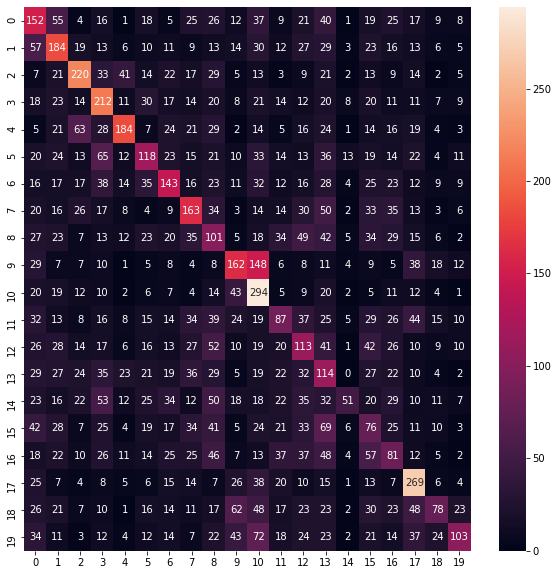

In [17]:
import seaborn as sns

cm = metrics.confusion_matrix(test_labels, predictions)
plt.figure(figsize = (10,10))
sns.heatmap(cm,annot=True,fmt='g')
plt.savefig('Observations\KNN_Confusion_Matrix.png')
plt.show()

# Random Forests Implementation and Analysis on the CIFAR-100 Dataset

We showcase our experimental observations here as the preprocessing steps are exactly the same as the KNN implementation. In the case of Random Forests, we perform grid search over the max_depth parameter and monitor the accuracy using 10-fold cross validation.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

train_labels = train_labels.reshape((train_labels.shape[0],))
test_labels = test_labels.reshape((test_labels.shape[0],))

for n in [5,10,15,20,25,30]:
    
    model = RandomForestClassifier(max_depth=n, random_state=0)
    accs = cross_val_score(model, train_data, train_labels, cv=10)
    acc = np.mean(accs)
    
    model.fit(train_data, train_labels)
    predictions = model.predict(test_data)
    correct = np.where(predictions == test_labels,1,0)
    print('Depth = ' ,n, ' CV_Accuracy = ', acc,' Test Accuracy = ', np.sum(correct)/len(test_labels))

Depth =  5  CV_Accuracy =  0.22931999999999997  Test Accuracy =  0.2236
Depth =  10  CV_Accuracy =  0.28840000000000005  Test Accuracy =  0.2869
Depth =  15  CV_Accuracy =  0.32330000000000003  Test Accuracy =  0.3215
Depth =  20  CV_Accuracy =  0.3338  Test Accuracy =  0.3274
Depth =  25  CV_Accuracy =  0.33662  Test Accuracy =  0.3396
Depth =  30  CV_Accuracy =  0.33774  Test Accuracy =  0.3387


In [12]:
from sklearn import metrics

Depth = 30 #best hyperparameter

model = RandomForestClassifier(max_depth=n, random_state=0)
model.fit(train_data, train_labels)
predictions = model.predict(test_data)
correct = np.where(predictions == test_labels,1,0)
print('k = ' ,Depth, ' CV_Accuracy = ', acc,' Test Accuracy = ', np.sum(correct)/len(test_labels))


print(metrics.classification_report(test_labels, predictions))

k =  30  CV_Accuracy =  0.33774  Test Accuracy =  0.3387
              precision    recall  f1-score   support

           0       0.34      0.34      0.34       500
           1       0.38      0.36      0.37       500
           2       0.43      0.59      0.49       500
           3       0.39      0.33      0.36       500
           4       0.41      0.44      0.43       500
           5       0.33      0.28      0.30       500
           6       0.33      0.32      0.33       500
           7       0.34      0.40      0.37       500
           8       0.21      0.24      0.22       500
           9       0.38      0.50      0.43       500
          10       0.49      0.53      0.51       500
          11       0.27      0.25      0.26       500
          12       0.22      0.26      0.24       500
          13       0.25      0.17      0.20       500
          14       0.33      0.34      0.33       500
          15       0.19      0.14      0.16       500
          16       0.21 

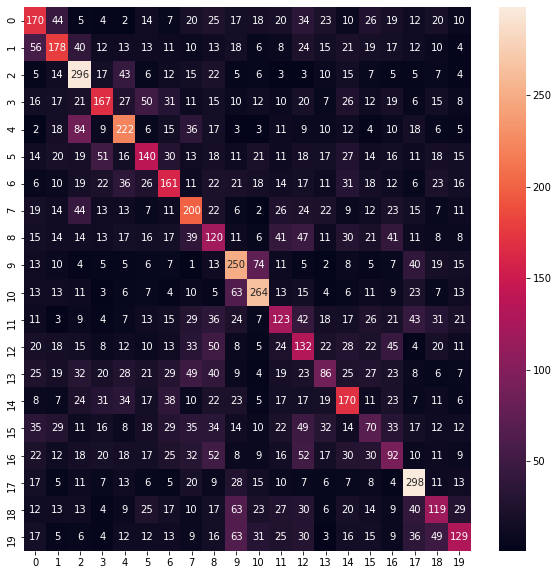

In [13]:
import seaborn as sns

cm = metrics.confusion_matrix(test_labels, predictions)
plt.figure(figsize = (10,10))
sns.heatmap(cm,annot=True,fmt='g')
plt.savefig('Observations\RandomForest_Confusion_Matrix.png')
plt.show()